#Import libraries

In [1]:
import os
import sys
from getpass import getpass
import git
import dropbox
import torch.optim as optim

#Configure environment

In [2]:
os.environ["ENVIRONMENT"] = "windows"
os.environ["REPO_DIR"] = git.Repo(search_parent_directories=True).git.rev_parse("--show-toplevel")
os.environ["ROOT_DIR"] = os.path.abspath(os.path.join(os.getenv("REPO_DIR"), os.pardir))
os.environ["MODEL_ID"] = "2y1a08e3"
os.environ["MODEL_DIR"] = f"{os.getenv('REPO_DIR')}/models/model_{os.getenv('MODEL_ID')}"

#Import repository resources

In [3]:
sys.path.append(f"{os.getenv('REPO_DIR')}/src")
from helpers import *

sys.path.append(f"{os.getenv('MODEL_DIR')}/src")
from methods import *
from architecture import *
from dataset import *

#Download datasets

In [9]:
dbx_access_token = getpass("Enter your DropBox access token: ")

In [ ]:
# download_datasets_from_dropbox(
#     dbx_access_token = dbx_access_token,
#     include_all_datasets = True,
#     use_thread = True
# )

#Code

In [10]:
num_epochs = 30
batch_size = 32
val_size = 50

In [12]:
device = set_device()
model = initialize_model(device=device, dbx_access_token=dbx_access_token, reset_weights=True)

train_dataset, val_dataset, benchmark_dataset = create_datasets(
    device = device,
    include_all_datasets = False,
    datasets = ["real_world/comp23_4", "real_world/f22_parking_lot_3"]
)

train_dataloader, val_dataloader, benchmark_dataloader = create_dataloaders(
    train_dataset = train_dataset,
    val_dataset = val_dataset,
    benchmark_dataset = benchmark_dataset,
    batch_size = batch_size,
    val_size = val_size
)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 3.0], device=device))

Using GPU!


In [13]:
model, train_loss_hist, val_performance_hist, best_val_performance = training_loop(
    model = model,
    criterion = criterion,
    optimizer = optimizer,
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    dbx_access_token = dbx_access_token,
    num_epochs = num_epochs,
    critiqueing_metric = "Mean Pixel Accuracy",
    auto_stop = False
)

Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch: 1/30  <>  Train Loss: 1.3974  <>  Val MPA: 24.38%  <>  Val Precision: 0.48%
Epoch: 5/30  <>  Train Loss: 1.3624  <>  Val MPA: 23.36%  <>  Val Precision: 0.53%
Epoch: 10/30  <>  Train Loss: 1.3320  <>  Val MPA: 22.37%  <>  Val Precision: 0.53%
Epoch: 15/30  <>  Train Loss: 1.3238  <>  Val MPA: 21.13%  <>  Val Precision: 0.58%
Epoch: 20/30  <>  Train Loss: 1.3212  <>  Val MPA: 20.37%  <>  Val Precision: 0.58%
Epoch: 25/30  <>  Train Loss: 1.3188  <>  Val MPA: 19.62%  <>  Val Precision: 0.57%
Epoch: 30/30  <>  Train Loss: 1.3139  <>  Val MPA: 19.01%  <>  Val Precision: 0.59%
Uploaded model weights to Dropbox.


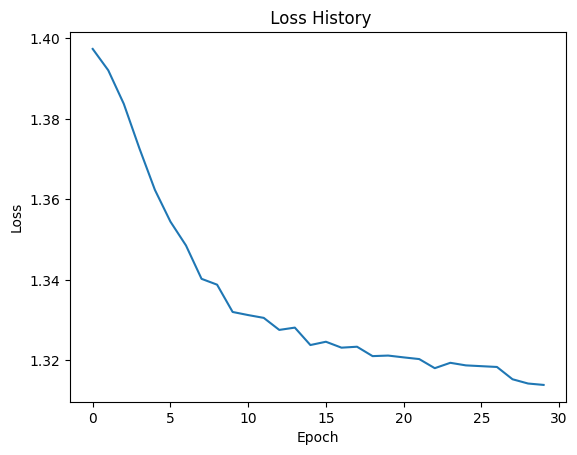

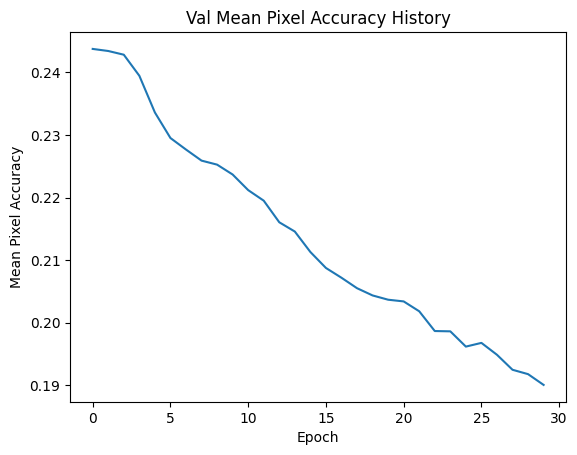

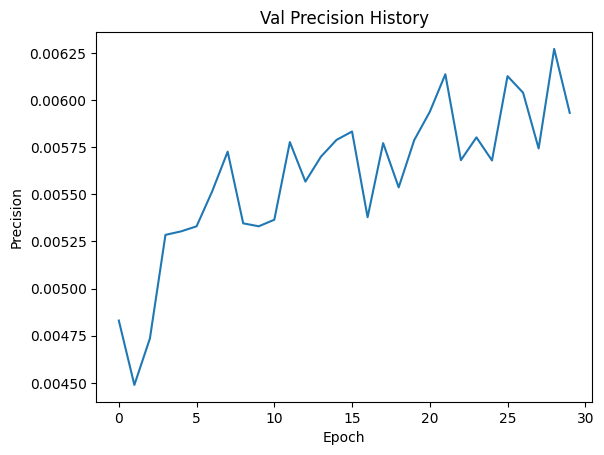

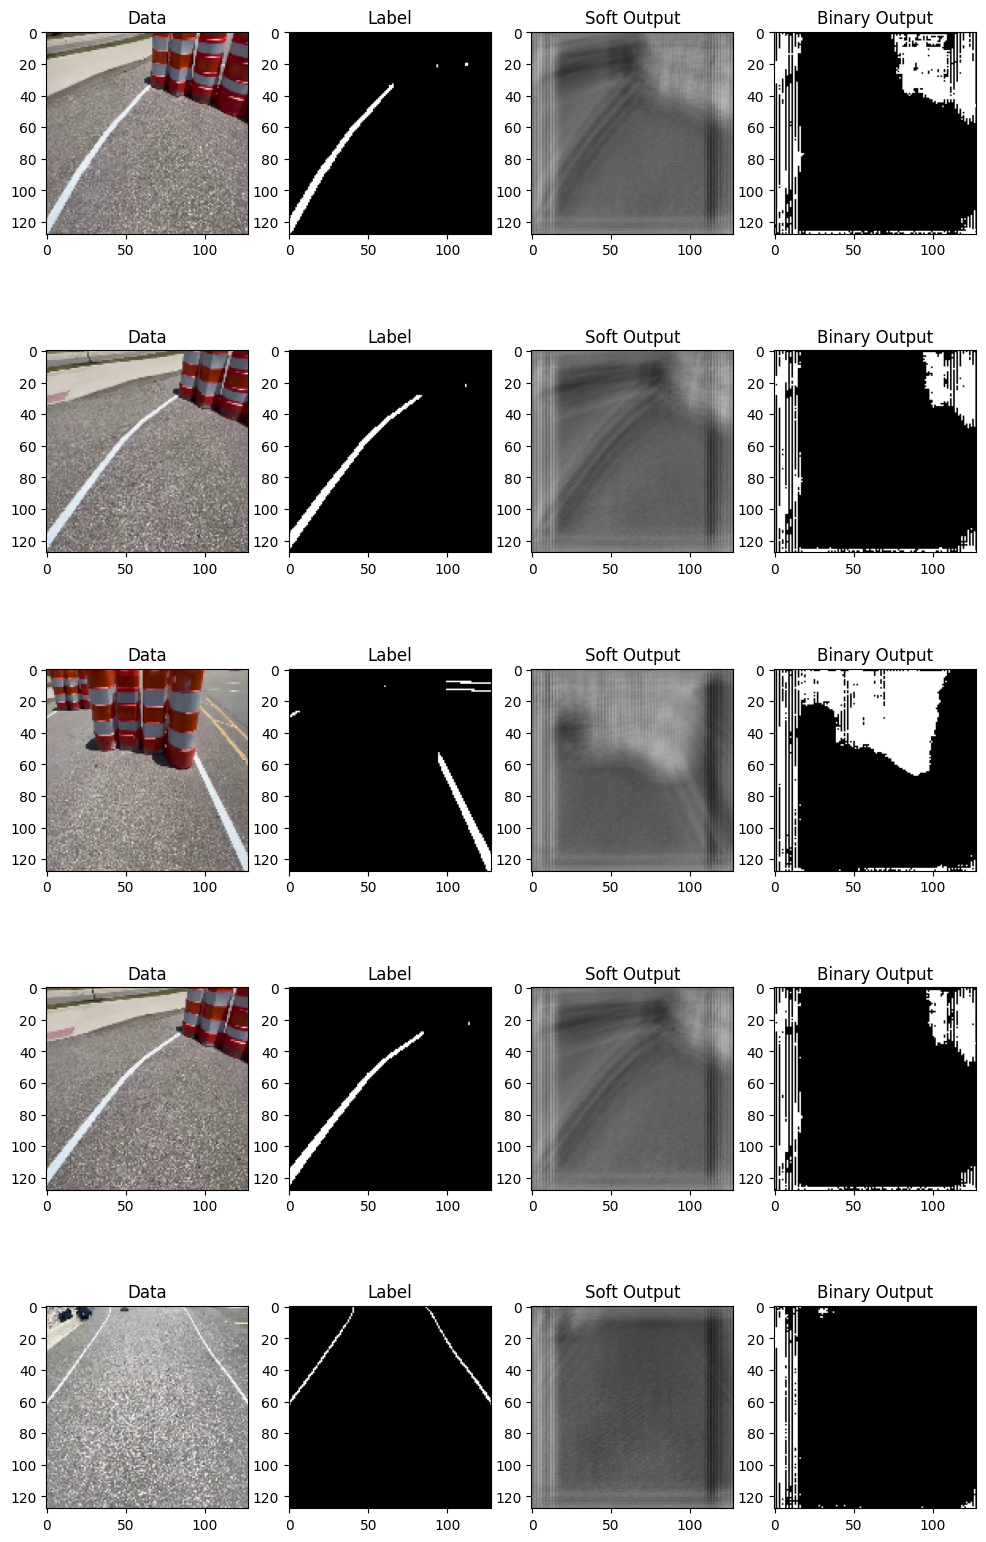

In [14]:
graph_loss_history(train_loss_hist)

graph_performance_history(
    performance_hist = val_performance_hist,
    split = 'Val',
    metrics = ["Mean Pixel Accuracy", "Precision"]
)

show_sample_results(
    model = model,
    dataset = train_dataset,
    device = device,
)

Testing on benchmark_1:   0%|          | 0/622 [00:00<?, ? frame/s]

Metrics saved in performance.json.

benchmark_1 metrics:
	TN Rate: 0.3756
	FP Rate: 0.6244
	TP Rate: 0.7655
	FN Rate: 0.2345
	Accuracy: 0.3776
	Precision: 0.0064
	Recall: 0.7655
	Specificity: 0.3756
	F1 Score: 0.0126
	IoU Lane: 0.0064
	IoU Background: 0.3751
	Mean IoU: 0.1908
	Pixel Accuracy: 0.3776
	Mean Pixel Accuracy: 0.1908
	Frequency-Weighted IoU: 0.3732
	Dice Coefficient: 0.0126
	Boundary F1 Score: 0.0126



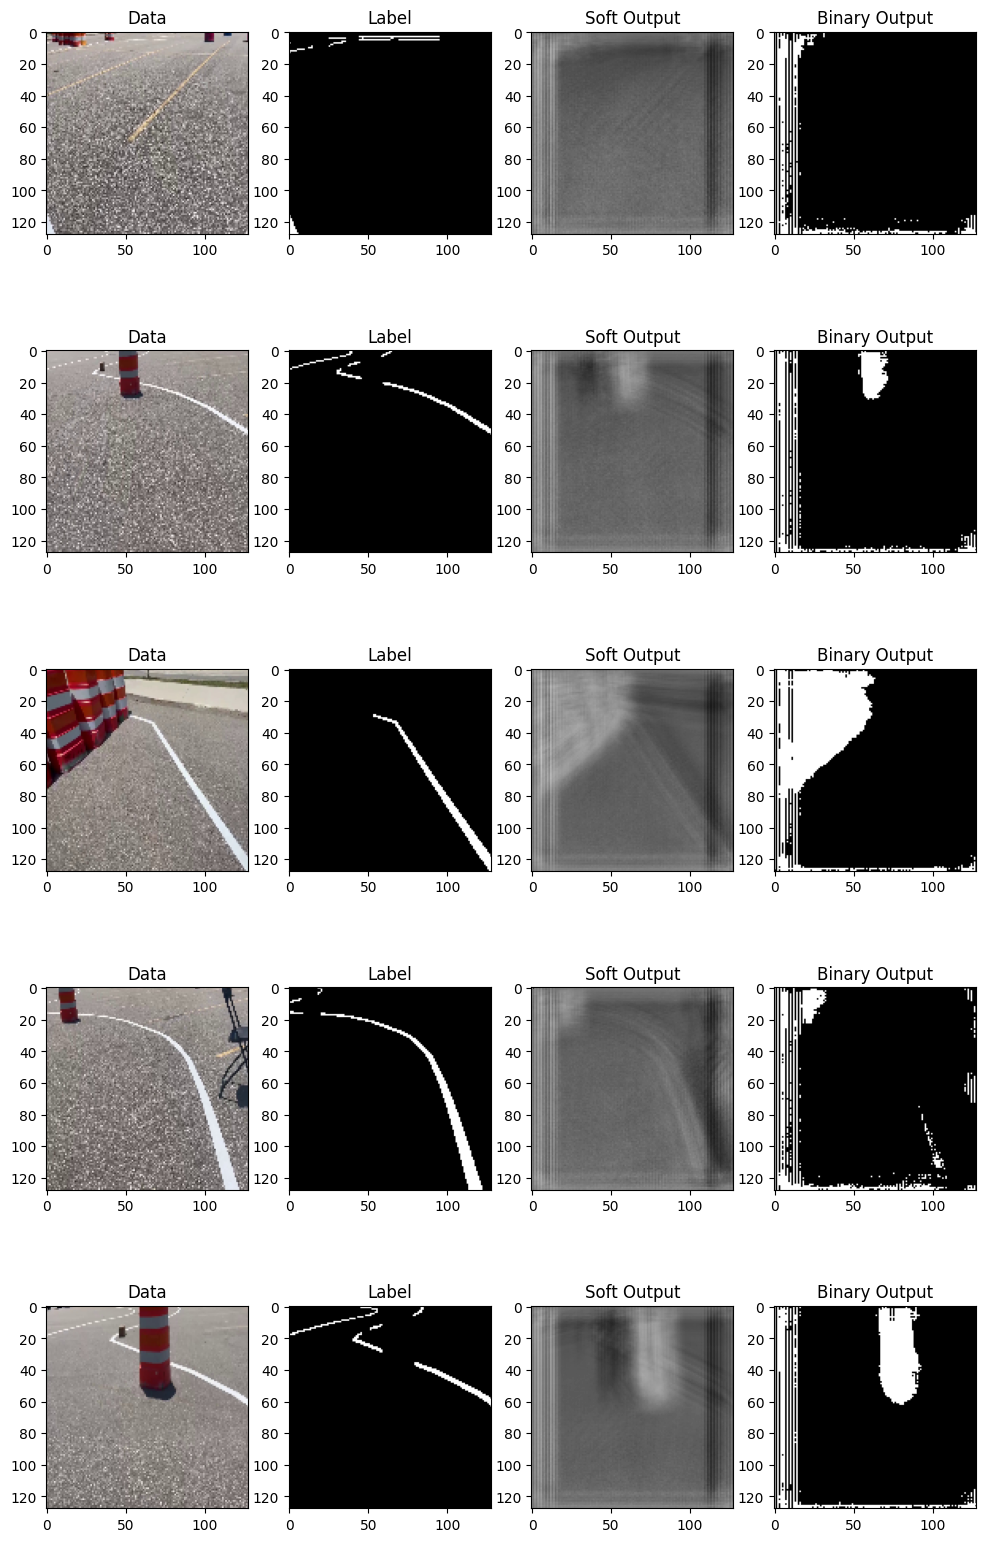

In [15]:
test_model_on_benchmarks(
    model = model,
    device = device,
    all_benchmarks = True,
    report_results = True
)